## Postprocessing

In this notebook, we will highlight the main quality metrics and the major sanity checks that should be done while performing the manual curation of a spike sorting

In [24]:
import spikeinterface.full as si
import probeinterface
from pathlib import Path
import matplotlib.pyplot as plt

In [25]:
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)

Let's take a real openephys recording, and launch a spike sorting pipeline to get the results



In [56]:
base_folder = Path('/home/samuel/DataSpikeSorting/Aussois_SI_tutorial/')
# base_folder = Path('/data_local/DataSpikeSorting/Aussois_SI_tutorial')
oe_folder = base_folder / 'openephys_recording/2023-08-23_15-56-05'


In [27]:
recording = si.read_openephys(oe_folder)

probe = probeinterface.get_probe('cambridgeneurotech',  'ASSY-236-H5')
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
recording = recording.set_probe(probe)
recording



ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

(-50.0, 150.0)

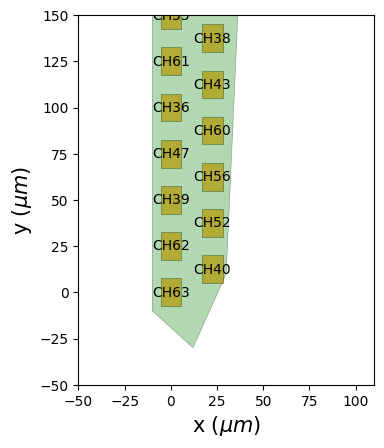

In [33]:
%matplotlib inline
fgi, ax = plt.subplots()
si.plot_probe_map(recording, with_channel_ids=True, ax=ax)
ax.set_ylim(-50, 150)


## clean recording

* filter
* remove bad channels
* CMR

In [37]:

recording_f = si.highpass_filter(recording, freq_min=150, dtype='float32')
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f)
print("Some bad channels are detected", bad_channel_ids)
recording_f = recording_f.remove_channels(bad_channel_ids)
recording_f = si.common_reference(recording_f)
print(recording_f)


Some bad channels are detected ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH40' 'CH57' 'CH58'
 'CH59' 'CH60' 'CH61' 'CH64']
CommonReferenceRecording: 49 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - float32 dtype - 1.64 GiB


In [38]:
%matplotlib widget
si.plot_traces(recording_f, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [39]:
sorting = si.run_sorter('spykingcircus2', recording_f,
                        output_folder=base_folder / 'sorter_SC2',
                        verbose=True, apply_preprocessing=False)

Recording too large to be preloaded in RAM...
detect peaks using locally_exclusive with n_jobs = 3 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 125498 peaks in total
We kept 125498 peaks for clustering
extracting features with n_jobs = 3 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

estimate_templates with n_jobs = 3 and chunk_size = 30000


estimate_templates:   0%|          | 0/300 [00:00<?, ?it/s]

We found 76 raw clusters, starting to clean with matching...


/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 71 non-duplicated clusters...
estimate_templates with n_jobs = 3 and chunk_size = 30000


estimate_templates:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 3 and chunk_size = 3000


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 132338 spikes
spykingcircus2 run time 211.82s


In [42]:
sorting = si.read_sorter_folder(base_folder / 'sorter_SC2')
sorting

NumpyFolderSorting: 71 units - 1 segments - 30.0kHz

First, we need to create the analyzer

In [44]:
analyzer = si.create_sorting_analyzer(sorting, recording_f, format='memory', sparse=True, **job_kwargs)
analyzer

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 71 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions: 

In [ ]:
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms", ms_before=1.2, ms_after=2.5)
analyzer.compute("templates", operators=["average", "std"])
analyzer.compute("noise_levels")

analyzer

In [47]:
analyzer.compute({
    "random_spikes" : dict(method="uniform", max_spikes_per_unit=500),
    "waveforms" :  dict(ms_before=1.2, ms_after=2.5),
    "templates" : dict(operators=["average", "std"]),
    "noise_levels": dict(),
}, **job_kwargs)
analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 71 units - 1 segments - memory - sparse - has recording
Loaded 4 extensions: random_spikes, noise_levels, waveforms, templates

In [49]:
analyzer.compute({
    "principal_components": dict(n_components=3, mode="by_channel_global"),
    "spike_amplitudes": dict(),
    "unit_locations": dict(method="monopolar_triangulation"),
    "spike_locations": dict(method="center_of_mass"),
    "template_similarity": dict(),
    "correlograms": dict(),
}, **job_kwargs)
analyzer

Fitting PCA:   0%|          | 0/71 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/71 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

spike_locations:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 49 channels - 71 units - 1 segments - memory - sparse - has recording
Loaded 10 extensions: random_spikes, noise_levels, waveforms, templates, principal_components, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms

# Computing the metrics

We need to compute some metrics on the spikes and waveforms that we have obtained

In [ ]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

In [51]:
metric_names = si.get_quality_metric_list()
metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names, **job_kwargs)
metrics

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:846: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
/home/samuel/.virtualenvs/py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/samuel/.virtualenvs/py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/samuel/.virtualenvs/py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,...,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
0,NaN,NaN,NaN,-142.952621,NaN,NaN,NaN,1.60,0.876667,1.445734,...,263.0,1.0,1.0,1.0,3.957444,NaN,18.012100,0.003802,0.000000,0.0
1,NaN,NaN,NaN,-187.796310,NaN,NaN,NaN,1.41,0.833333,0.000000,...,250.0,1.0,0.0,0.0,6.291379,NaN,20.840533,0.032000,0.000000,0.0
2,NaN,NaN,NaN,-173.173767,NaN,NaN,NaN,1.41,0.893333,1.392292,...,268.0,1.0,1.0,1.0,6.143502,NaN,22.586345,0.022388,0.000000,0.0
3,0.002044,0.289639,0.070605,-162.567139,0.296674,0.110731,0.078916,2.60,2.313333,3.529636,...,694.0,1.0,1.0,11.0,4.607011,NaN,20.709304,0.015850,0.000000,0.0
4,NaN,NaN,NaN,-181.282410,NaN,NaN,NaN,1.21,0.610000,5.972110,...,183.0,1.0,1.0,1.0,7.248888,NaN,27.196672,0.038251,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.000743,0.401984,0.143241,-43.706036,0.381244,0.150957,0.122335,6.02,10.263333,1.307984,...,3079.0,1.0,1.0,86.0,2.742523,NaN,7.078446,0.014615,0.000325,0.0
67,0.000636,0.556546,0.416586,-13.062435,0.351862,0.131921,0.104302,21.05,17.306667,0.908859,...,5192.0,1.0,1.0,205.0,0.985975,NaN,1.940066,0.011171,0.000000,0.0
68,0.000515,0.377179,0.134274,-27.138512,0.303564,0.117709,0.121475,6.00,5.413333,2.274988,...,1624.0,1.0,1.0,43.0,1.485586,NaN,4.169258,0.025246,0.000000,0.0
69,0.000185,NaN,NaN,-12.823603,0.256096,0.103319,0.106984,40.41,27.606667,1.108009,...,8282.0,1.0,1.0,689.0,0.967531,NaN,1.943378,0.006882,0.000000,0.0


In [52]:
analyzer

SortingAnalyzer: 49 channels - 71 units - 1 segments - memory - sparse - has recording
Loaded 11 extensions: random_spikes, noise_levels, waveforms, templates, principal_components, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms, quality_metrics

In [53]:
metrics = analyzer.get_extension("quality_metrics").get_data()
metrics

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,...,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
0,NaN,NaN,NaN,-142.952621,NaN,NaN,NaN,1.60,0.876667,1.445734,...,263.0,1.0,1.0,1.0,3.957444,NaN,18.012100,0.003802,0.000000,0.0
1,NaN,NaN,NaN,-187.796310,NaN,NaN,NaN,1.41,0.833333,0.000000,...,250.0,1.0,0.0,0.0,6.291379,NaN,20.840533,0.032000,0.000000,0.0
2,NaN,NaN,NaN,-173.173767,NaN,NaN,NaN,1.41,0.893333,1.392292,...,268.0,1.0,1.0,1.0,6.143502,NaN,22.586345,0.022388,0.000000,0.0
3,0.002044,0.289639,0.070605,-162.567139,0.296674,0.110731,0.078916,2.60,2.313333,3.529636,...,694.0,1.0,1.0,11.0,4.607011,NaN,20.709304,0.015850,0.000000,0.0
4,NaN,NaN,NaN,-181.282410,NaN,NaN,NaN,1.21,0.610000,5.972110,...,183.0,1.0,1.0,1.0,7.248888,NaN,27.196672,0.038251,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.000743,0.401984,0.143241,-43.706036,0.381244,0.150957,0.122335,6.02,10.263333,1.307984,...,3079.0,1.0,1.0,86.0,2.742523,NaN,7.078446,0.014615,0.000325,0.0
67,0.000636,0.556546,0.416586,-13.062435,0.351862,0.131921,0.104302,21.05,17.306667,0.908859,...,5192.0,1.0,1.0,205.0,0.985975,NaN,1.940066,0.011171,0.000000,0.0
68,0.000515,0.377179,0.134274,-27.138512,0.303564,0.117709,0.121475,6.00,5.413333,2.274988,...,1624.0,1.0,1.0,43.0,1.485586,NaN,4.169258,0.025246,0.000000,0.0
69,0.000185,NaN,NaN,-12.823603,0.256096,0.103319,0.106984,40.41,27.606667,1.108009,...,8282.0,1.0,1.0,689.0,0.967531,NaN,1.943378,0.006882,0.000000,0.0


# Export to phy

For those that are interested, you can simply export to phy via SpikeInterface

In [59]:
si.export_to_phy(analyzer,
    output_folder=base_folder / 'phy_SC2',
    compute_pc_features=False,
    compute_amplitudes=True,
    copy_binary=False,
    **job_kwargs)
import os

#os.system('phy template-gui /home/pierre/data/sorting/nick/dataset1/phy/params.py')

Run:
phy template-gui  /home/samuel/DataSpikeSorting/Aussois_SI_tutorial/phy_SC2/params.py


# Slicing your results

You can easily obtain some units by combining some quality metrics

In [72]:
## Get unit_ids
good_units_ids = metrics.query('snr > 5 & rp_contamination < 0.5').index.tolist()
print(good_units_ids)

[1, 23, 32, 39, 47, 48, 61]


In [73]:
bad_units_ids = metrics.query('rp_contamination > 0.8').index.tolist()
bad_units_ids

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 43,
 44,
 45,
 46,
 49,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70]

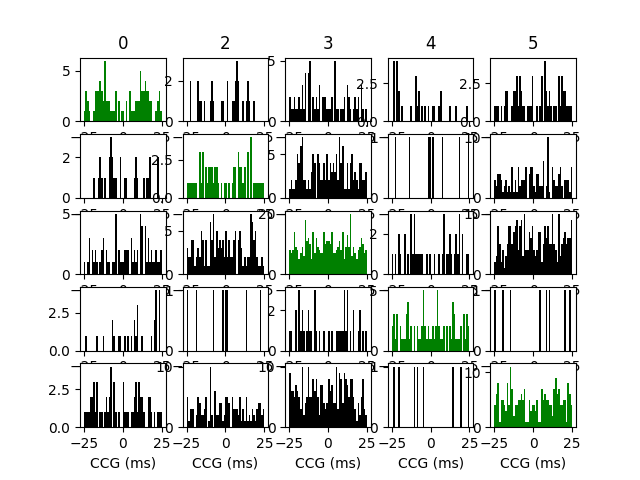

In [74]:
si.plot_crosscorrelograms(analyzer, unit_ids=bad_units_ids[:5])

# Auto merge (Lussac module)

Eventually, you can have a list of putative merges that should be done (and could be done)

In [75]:
si.get_potential_auto_merge(analyzer)

[]

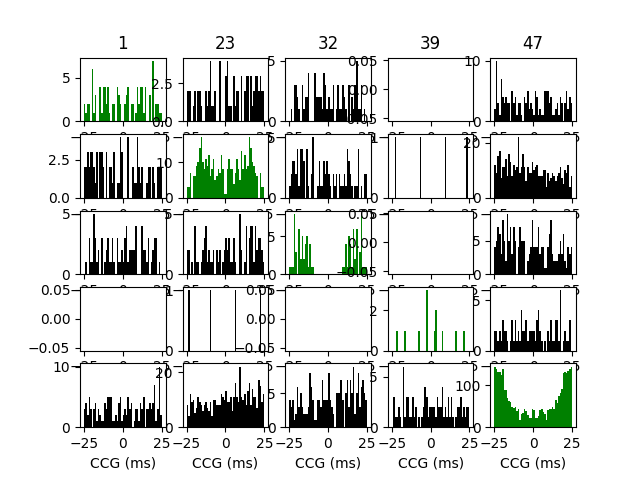

In [76]:
si.plot_crosscorrelograms(analyzer, good_units_ids[:5])

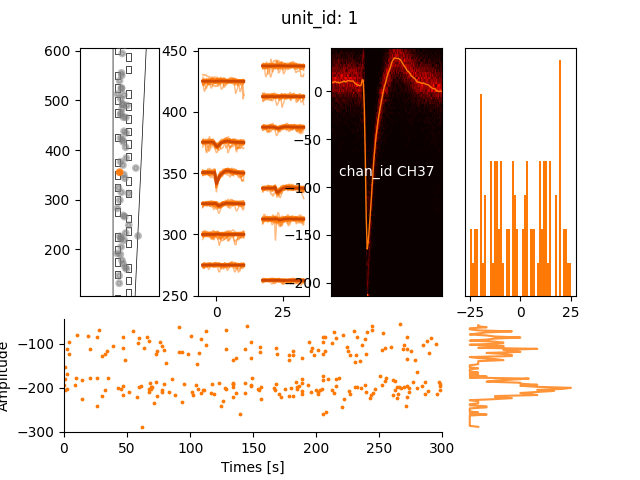

In [77]:
si.plot_unit_summary(analyzer, unit_id=good_units_ids[0])

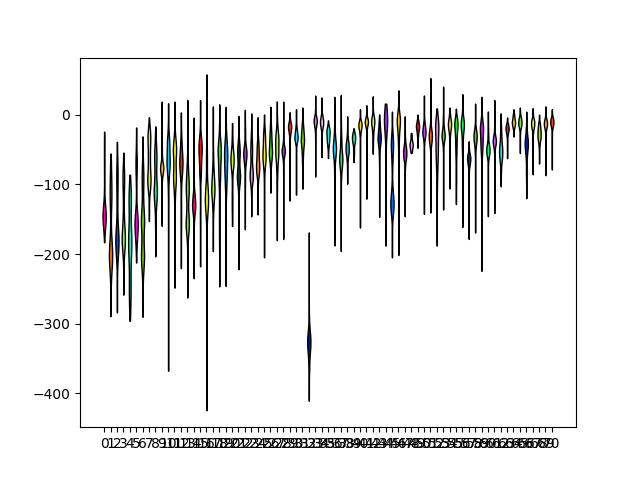

In [78]:
si.plot_all_amplitudes_distributions(analyzer)

In [79]:
%matplotlib widget
si.plot_unit_templates(analyzer, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

## create clean analyazer


In [83]:
analyzer_clean = analyzer.select_units(good_units_ids)
analyzer_clean

SortingAnalyzer: 49 channels - 7 units - 1 segments - memory - sparse - has recording
Loaded 11 extensions: random_spikes, noise_levels, waveforms, templates, principal_components, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms, quality_metrics

In [ ]:
%gui qt
si.plot_sorting_summary(analyzer_clean, backend="spikeinterface_gui")


In [86]:

si.plot_sorting_summary(analyzer_clean, backend="sortingview")


https://figurl.org/f?v=gs://figurl/sortingview-11&d=sha1://09eb2e63798a74b3dd6e437a046b9878f9b7a369
